# **Customer Segmentation Analysis**

**Project Goal:** The objective of this project is to perform customer segmentation for an e-commerce business using RFM (Recency, Frequency, Monetary) analysis and the K-Means clustering algorithm. By identifying distinct customer groups, we can provide targeted marketing recommendations to improve customer engagement and profitability.

**Methodology:**



1.    **Data Cleaning:** Process raw transactional data to make it suitable for analysis.

2.   **Feature Engineering:** Calculate Recency, Frequency, and Monetary scores for each customer.



3.   **Clustering:** Apply the K-Means algorithm to segment customers based on their RFM scores.
4.   **Analysis & Recommendations:**  Analyze the characteristics of each segment and propose targeted business strategies.

**Dataset:** Online Retail Dataset from UCI Machine Learning Repository.







**1. Project Setup and Data Loading**

In this step, we install the necessary libraries, download the dataset directly into the Colab environment, and load it into a pandas DataFrame for initial inspection.

In [1]:
# === Part 1: Install library needed to read Excel files ===
!pip install openpyxl

# === Part 2: Download the dataset directly from the source ===
# This command downloads the zip file into our Colab environment
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

# === Part 3: Load the libraries and the data ===
import pandas as pd
import numpy as np
import datetime as dt

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Online Retail.xlsx')

print("Setup complete. Data loaded successfully!")

# === Part 4: Initial exploration ===
# Display the first 5 rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display a summary of the DataFrame
print("\nDataset Information:")
df.info()

--2025-09-15 02:54:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [        <=>         ]  22.62M  10.6MB/s    in 2.1s    

2025-09-15 02:54:08 (10.6 MB/s) - ‘Online Retail.xlsx’ saved [23715344]

Setup complete. Data loaded successfully!

First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTI

**2. Data Cleaning and Preprocessing**

Raw transactional data often contains issues like missing values, returns (negative quantities), and duplicates. This step is crucial for ensuring the quality of our analysis.



In [2]:
# Display the original size of the dataset
print(f"Original data shape: {df.shape}")

# --- Part 1: Handle Missing Values ---
# We need CustomerID to analyze customers, so we drop rows where it's missing.
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Shape after dropping missing CustomerIDs: {df.shape}")

# --- Part 2: Handle Canceled Orders and Invalid Data ---
# Canceled orders have invoice numbers starting with 'C' and often negative quantities.
# We will also remove any items with a price of zero or less.
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
print(f"Shape after removing returns and invalid data: {df.shape}")

# --- Part 3: Remove Duplicate Rows ---
df.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

# --- Part 4: Fix Data Types ---
# Convert CustomerID to an integer for cleaner data.
df['CustomerID'] = df['CustomerID'].astype(int)

print("\n--- Cleaned Data Info ---")
df.info()

Original data shape: (541909, 8)
Shape after dropping missing CustomerIDs: (406829, 8)
Shape after removing returns and invalid data: (397884, 8)
Shape after dropping duplicates: (392692, 8)

--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


**3. Feature Engineering: RFM Calculation**

We now transform the cleaned transaction data into RFM metrics for each customer.


*   **Recency (R):** Days since the customer's last purchase.



*   **Frequency (F):** Total number of separate purchases made.


*   **Monetary (M):** Total money spent by the customer.

In [3]:
# --- Part 1: Calculate TotalPrice for each transaction ---
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# --- Part 2: Calculate RFM metrics for each customer ---
# Set a snapshot date for recency calculation (one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by customer and calculate RFM values
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# --- Part 3: Rename the columns for clarity ---
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'Monetary'}, inplace=True)

# --- Part 4: Display the first 5 rows of the new RFM table ---
print("RFM DataFrame:")
rfm_df.head()

RFM DataFrame:


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


**4. Customer Segmentation with K-Means**

With our RFM features ready, we can now use the K-Means clustering algorithm. First, we must scale the data and use the Elbow Method to find the optimal number of clusters.

--- RFM Data Summary ---
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2048.688081
std     100.014169     7.697998    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   209.000000  280206.020000


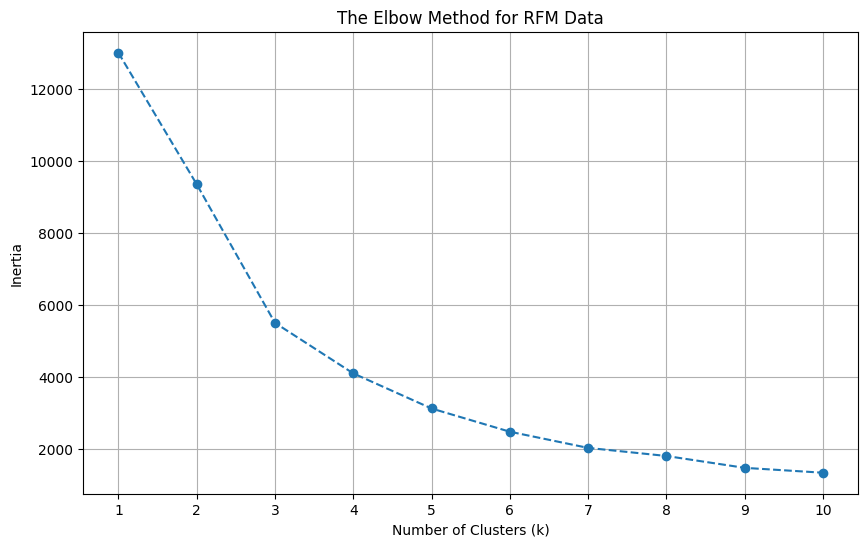

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Part 1: Check the distribution of the RFM data ---
print("--- RFM Data Summary ---")
print(rfm_df.describe())


# --- Part 2: Scale the RFM data ---
# Scaling is crucial for distance-based algorithms like K-Means
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

# Convert the scaled array back to a DataFrame for easier use
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_df.columns)


# --- Part 3: Find the optimal number of clusters using the Elbow Method ---
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled)
    inertia_list.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_list, marker='o', linestyle='--')
plt.title('The Elbow Method for RFM Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

Based on the Elbow Method plot, k=4 is the optimal number of clusters. We will now apply the final model.


In [5]:
# --- Part 1: Run the final K-Means model with k=4 ---
final_kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init='auto')

# Add the cluster labels back to the original (unscaled) RFM DataFrame
rfm_df['Cluster'] = final_kmeans.fit_predict(rfm_scaled)


# --- Part 2: Analyze the characteristics of each cluster ---
# Calculate the average RFM values for each cluster
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] # Also count the number of customers in each segment
}).round(2)

print("--- Analysis of Customer Segments ---")
print(cluster_analysis)

--- Analysis of Customer Segments ---
        Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         43.70      3.68    1353.63  3054
1        248.08      1.55     478.85  1067
2          7.38     82.54  127187.96    13
3         15.50     22.33   12690.50   204


**5. Insights and Recommendations**
The K-Means algorithm successfully segmented customers into four distinct groups. We can now analyze their characteristics and assign them meaningful personas.

**Cluster 2: Champions (VIPs)**

*   **Analysis:** This is a small group of elite customers with extremely low Recency, the highest Frequency, and the highest Monetary value. They are the most loyal and profitable.

*   **Recommendation:** Focus on retention and reward. Offer loyalty programs, exclusive access to new products, and personalized communication.

**Cluster 3: Loyal Customers**

*  **Analysis:** This group shops recently and frequently, with high monetary value, but are a step below the Champions.

*   **Recommendation:** Nurture them to become Champions. Offer membership benefits, cross-sell related products, and engage them with new arrivals.

**Cluster 0: Standard Customers**

*   **Analysis:** This is the largest segment, representing the average customer with moderate Recency, Frequency, and Monetary scores.
*   **Recommendation:** Keep them engaged with consistent marketing, seasonal promotions, and content that builds brand loyalty. The goal is to increase their purchase frequency.

**Cluster 1: At-Risk / Lost Customers**

*   **Analysis:** This large group has a very high Recency (haven't purchased in a long time) and low Frequency/Monetary values.

*   **Recommendation:** Launch a targeted "win-back" campaign. Send personalized emails with a special discount or offer to re-engage them before they are lost for good.









**6. Conclusion**

This project successfully demonstrated the end-to-end process of customer segmentation using RFM analysis and K-Means clustering. By analyzing raw transactional data, we engineered features that summarize customer behavior and grouped them into four actionable segments: Champions, Loyal Customers, Standard Customers, and At-Risk Customers.

The key takeaway is that the customer base is not uniform. A one-size-fits-all marketing approach is inefficient. By adopting the targeted strategies recommended for each segment, the business can significantly improve customer retention, increase profitability, and foster stronger customer relationships.